# Analysing Information from Movie Dataset

## Introduction

In this project, the data from movies, users and ratings was analised in order to acomplish the movie rating prediction task.
  
We will focus on *collaborative filtering* models, which can be generally split into two classes: user-based collaborative filtering and item-based collaborative filtering. In either scenario, one builds a similarity matrix. For item-based collaborative filtering (in this case is movie-based), the item-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of items. Likewise, the user-similarity matrix will measure the similarity between any two pairs of users.
  
Models are trained with **Item-based K nearest neighbours (KNN)** and **User-based K nearest neighbours (KNN)**.
Afterwards, the error is calculated. By comparing the rate prediction error (*Mean Square Error* - MSE and *Mean Absolute Error* - MAE), we are able to evaluate the performance of the proposed model.  
  
The goal is to build simulation of recommendation system using provided data, which recommends movies to the user to meet their preference as well as possible. Therefore, the main task is to predict how the user will rate movies that he/she has not watched, and recommend those with higher potential ratings.

## Dataset

Dataset is downloaded from the following link: [movie recommend data](http://www.vukmalbasa.com/poslovna-inteligencija/file/movie%20recommend%20data.zip?attredirects=0&d=1).

Dataset format:  
    1. Movie.txt
    2. Peson.txt 
    3. Vote.txt


Let's look inside the files. But first we need to load some dependencies.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load data

We will load the data and store it in a pandas dataframe. Why we will use pandas? Because the fundamental behaviour about data types, indexing, and axis labeling apply across all of the objects. We can name columns and manipulate data easily, and the links we make between data will stay consistent unless we change it explicitly.

In [2]:
data_dir = '../data/'

In [3]:
# users file
user_columns = ['user_id', 'age', 'sex', 'zip_code']
users = pd.read_csv(data_dir + 'Person.txt', sep='\t', names=user_columns, encoding='latin-1')

In [4]:
# ratings file
vote_columns = ['user_id', 'movie_id', 'rating1', 'rating2', 'unix_timestamp']
votes = pd.read_csv(data_dir + 'Vote.txt', sep='\t', names=vote_columns, encoding='latin-1')

In [5]:
# movies file
movie_columns = ['movie_id', 'movie_title', 'site_link', 'IMDb_URL', 'release_date', 'release_date_relative', 'video_release_date', 'video_release_date_relative', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy']
movies = pd.read_csv(data_dir + 'Movie.txt', sep='\t', names=movie_columns, encoding='latin-1')

We will create merged table that consists of all the read data combined. We are merging this data in order to make some interesting plots easier later.

In [6]:
# merge users, movies, and votes data
movie_ratings = pd.merge(movies, votes)
merged_table = pd.merge(movie_ratings, users)

### Tables

In [7]:
# users
users.head()

user_id   age  sex zip_code
0        1  42.0    M    94025
1       10  38.0    F    94025
2       16   NaN  NaN      NaN
3       17   NaN  NaN      NaN
4       18   NaN  NaN      NaN

We see that the only information we get about the user is their ID, age, gender and probably zip code. Zip code will not be used for extracting any relevant information later. We also see that some of users don't have specified age, gender nor zip code.

In [8]:
# votes
votes.head()

user_id  movie_id  rating1  rating2     unix_timestamp
0        1         1      0.6      1.0   4/15/96 13:16:00
1        1         2      0.6      1.0  10/22/96 16:37:31
2        1        10      0.4      1.0  10/26/96 15:07:36
3        1        13      0.0      0.2   4/15/96 12:13:36
4        1        17      0.8      1.0    9/18/96 9:22:08

In the votes dataset, we can see that every user-movie relation is described additionaly with the **rating1** rating that user gave to that movie (on the scale from 0 to 1), **rating2** time that user spent before rating the movie, and timestamp when the user rated the movie. User-movie relation is represented using their IDs. 

In [9]:
# movies
movies.head()

movie_id                  movie_title  \
0         1                    Toy Story   
1         2                      Jumanji   
2         3             Grumpier Old Men   
3         4            Waiting to Exhale   
4         5  Father of the Bride Part II   

                                           site_link  \
0                            http://www.toystory.com   
1  http://www.spe.sony.com/Pictures/SonyMovies/Ju...   
2                                                NaN   
3                                                NaN   
4  http://www.movienet.com/movienet/movinfo/fathe...   

                                            IMDb_URL release_date  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          old   
1  http://us.imdb.com/M/title-exact?Jumanji%20(1995)          old   
2  http://us.imdb.com/M/title-exact?Grumpier%20Ol...          old   
3  http://us.imdb.com/M/title-exact?Waiting%20to%...          old   
4  http://us.imdb.com/M/title-exact?Father%20of%2...          old   

  release_date_relative video_release_date video_release_date_relative  \
0                   NaN            current            10/30/96 0:00:00   
1                   NaN                old             5/14/96 0:00:00   
2                   NaN            current              6/4/96 0:00:00   
3       1/15/96 0:00:00                old             4/23/96 0:00:00   
4                   NaN            current             6/11/96 0:00:00   

   unknown  Action  Adventure  Animation  Children's  Comedy  Crime  \
0        0       1          0          0           0       0      1   
1        0       0          0          0           0       0      1   
2        0       0          0          0           1       0      0   
3        0       0          0          0           0       1      0   
4        0       0          0          0           1       0      0   

   Documentary  Drama  Fantasy  
0            0      0        0  
1            0      0        0  
2            0      0        0  
3            0      0        0  
4            0      0        0

Movie datasets consist of movies described with their ID, title, link to the movie, link to the IMDB, relative release date and the exact release date, video release date and the exact video release date, and 10 genres (1-True, 0-False).

In [10]:
# merged table
merged_table.head()

movie_id            movie_title  \
0         1              Toy Story   
1         2                Jumanji   
2        10              Goldeneye   
3        13                  Balto   
4        17  Sense and Sensibility   

                                           site_link  \
0                            http://www.toystory.com   
1  http://www.spe.sony.com/Pictures/SonyMovies/Ju...   
2               http://www.mgmua.com/bond/index.html   
3            http://www.mca.com/ppv/balto/index.html   
4  http://www.spe.sony.com/Pictures/SonyMovies/se...   

                                            IMDb_URL release_date  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          old   
1  http://us.imdb.com/M/title-exact?Jumanji%20(1995)          old   
2  http://us.imdb.com/M/title-exact?GoldenEye%20(...          old   
3    http://us.imdb.com/M/title-exact?Balto%20(1995)          old   
4  http://us.imdb.com/M/title-exact?Sense%20and%2...          old   

  release_date_relative video_release_date video_release_date_relative  \
0                   NaN            current            10/30/96 0:00:00   
1                   NaN                old             5/14/96 0:00:00   
2                   NaN                old             5/21/96 0:00:00   
3                   NaN                old              4/5/96 0:00:00   
4                   NaN                old             6/25/96 0:00:00   

   unknown  Action    ...     Documentary  Drama  Fantasy  user_id  rating1  \
0        0       1    ...               0      0        0        1      0.6   
1        0       0    ...               0      0        0        1      0.6   
2        1       0    ...               0      0        0        1      0.4   
3        0       1    ...               0      0        0        1      0.0   
4        0       0    ...               0      1        0        1      0.8   

   rating2     unix_timestamp   age  sex  zip_code  
0      1.0   4/15/96 13:16:00  42.0    M     94025  
1      1.0  10/22/96 16:37:31  42.0    M     94025  
2      1.0  10/26/96 15:07:36  42.0    M     94025  
3      0.2   4/15/96 12:13:36  42.0    M     94025  
4      1.0    9/18/96 9:22:08  42.0    M     94025  

[5 rows x 25 columns]

As told before, this merged table is just combination of data from previous three datasets. Therefore, there is no need of explaining the data twice.

In [11]:
print(list(merged_table))

['movie_id', 'movie_title', 'site_link', 'IMDb_URL', 'release_date', 'release_date_relative', 'video_release_date', 'video_release_date_relative', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'user_id', 'rating1', 'rating2', 'unix_timestamp', 'age', 'sex', 'zip_code']


### Total number of users, movies, and votes 

Now, let's see some numbers. What is the amount of data we have?

In [12]:
total_users = users.shape[0]
print(f'Total number of users: {total_users}')

Total number of users: 72916


In [13]:
total_movies = movies.shape[0]
print(f'Total number of movies: {total_movies}')

Total number of movies: 1628


In [14]:
total_votes = votes.shape[0]
print(f'Total number of votes: {total_votes}')

Total number of votes: 2811983


Let's keep in mind that:
- some of users that haven't voted. 
- some of users voted several times (for a different movie). 

#### Voting information

How many users voted? 

In [15]:
total_voters = votes.user_id.unique().shape[0]
print(f'Number of users who voted: {total_voters}')

Number of users who voted: 61265


Here we can see that **84%** of users voted for at least one movie.

How many movies have at least one vote?

In [16]:
total_voted_movies = votes.movie_id.unique().shape[0]
print(f'Number of movies users voted for: {total_voted_movies}')

Number of movies users voted for: 1623


We can see that users were really busy. Only 5 movies don't have the rating, so the rest of **99.69%** movies have at least one rating.

### What are the top 20 movies?

What are the top 20 movies based on the number of user who gave them the rating?

In [17]:
merged_table.movie_title.value_counts()[:20]

Batman (1989)                 32868
Dances With Wolves            32677
Apollo 13                     31263
Pulp Fiction                  30515
True Lies                     29383
Ace Ventura: Pet Detective    25994
Aladdin                       24378
The Fugitive                  24281
Batman Forever                24262
Die Hard: With a Vengeance    24003
Independence Day (ID4)        23605
Clear and Present Danger      22363
Forrest Gump                  21801
The Silence of the Lambs      21729
Twister                       21400
Dumb and Dumber               21024
Toy Story                     20725
12 Monkeys                    20635
Beauty and the Beast          20584
Jurassic Park                 20560
Name: movie_title, dtype: int64

We can see that movie *Batman (1989)* received the largest amount of ratings (almost **46%** of the users from this dataset rated for this movie).

What are the top 5 movies based on the time user spent before rating it?

In [23]:
rating_time = merged_table.groupby('movie_title').agg({'rating2': [np.sum]})
rating_time.sort_values([('rating2', 'sum')], ascending=False).head()

rating2
                        sum
movie_title                
Batman (1989)       32443.9
Dances With Wolves  32211.3
Apollo 13           31053.6
Pulp Fiction        29625.4
True Lies           28783.8

It seems that movies are in the same order as above, which can be explained that Batman movie has the largest amount of ratings so all these user have to spent some tome before rating it.

But, let's see what are the possible times spent on movie before rating it on the site.

In [19]:
merged_table.rating2.value_counts()

1.0    2559107
0.2     223134
0.5      29742
Name: rating2, dtype: int64

We can see that the values are in range from 0 to 1. That means that we don't have the exact time in minutes (nor hours), it seems relative to something. But, let's conclude that the higher the relative number is, the greater is the time spent on movie before rating it.

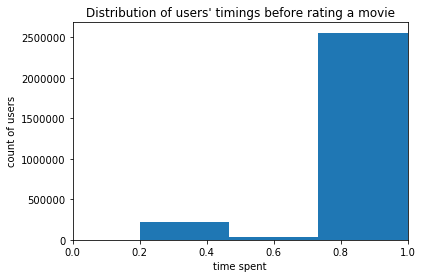

In [20]:
merged_table.rating2.plot.hist(bins=3)
plt.title("Distribution of users' timings before rating a movie")
plt.ylabel('count of users')
plt.xlabel('time spent');
plt.xlim([0,1])
plt.show()

Visual representation of time users spent before rating the movie. It seems that a lot of ratings are given with a careful thought.

In [21]:
merged_table.rating1.value_counts()

0.8    761676
0.6    701236
1.0    511667
0.0    347191
0.4    339718
0.2    150495
Name: rating1, dtype: int64

Here we can see that **27%** of ratings are 0.8 (the largest amount of ratings), **18%** are 1.0 (lovers), and **12.4%** are 0.0 (haters).

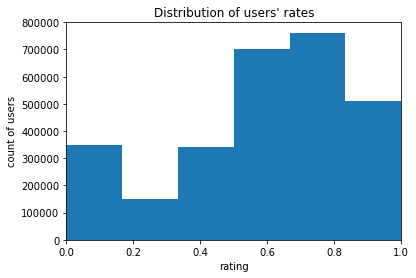

In [22]:
merged_table.rating1.plot.hist(bins=6)
plt.title("Distribution of users' rates")
plt.ylabel('count of users')
plt.xlabel('rating');
plt.xlim([0,1])
plt.show()

Visual representation of user ratings.

### Which movies are most highly rated?

First, calculate the average rating of the each movie.

In [23]:
movie_stats = merged_table.groupby('movie_title').agg({'rating1': [np.size, np.mean]})
movie_stats.head()

rating1          
                          size      mean
movie_title                             
'Til There Was You       111.0  0.450450
1-900                    179.0  0.320670
101 Dalmatians (1996)   3358.0  0.566289
12 Angry Men (1957)      624.0  0.837500
12 Monkeys             20635.0  0.691078

Here we can see that, for example, movie *'Til There Was You* has 111 ratings and the average rating of the movie is 0.45. The same way of reading information implies for the rest of the movies.

Now, we can sort movies by their average grade (from the best grade)

In [24]:
movie_stats.sort_values([('rating1', 'mean')], ascending=False).head()

rating1          
                                   size      mean
movie_title                                      
Schindler's List                12881.0  0.878410
The Wrong Trousers                957.0  0.877325
The Shawshank Redemption        19730.0  0.867592
Casablanca (1942)                1579.0  0.865611
Raiders of the Lost Ark (1981)   2825.0  0.863646

Movie *Schindler's List* has the highest average rating - 0.87 - in this dataset. The second movie in this list is *The Wrong Trousers* whit rating almost as high as *Schindler's List*.  

### What is the age of movie-likers?

Now, let's see the age distribution of users in our dataset.

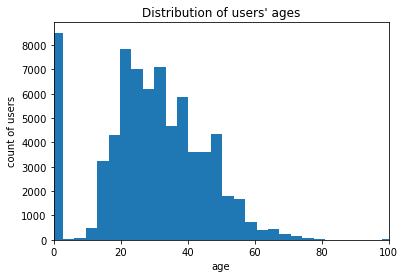

In [25]:
users.age.plot.hist(bins=300)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age');
plt.xlim([0,100])
plt.show()

On this plot we can see that more than 8000 users didn't specify their age. However, if we ignore them for a moment, we can see that largest amount users are in their **20s**.  
It is interesting to see that there are even a few people in their **100s** who rated some movies. Wow! 

#### Group users by their age

In order to easily find out interestig information related to users' ages in dataset, it is better to group users in age groups (users that have between 30-39), rather than having a few users within a certain age (users that have 37).

In [26]:
# be sure that the index is back to the initial
merged_table.reset_index('index', inplace=True)

In [27]:
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109']
merged_table['age_group'] = pd.cut(merged_table.age, range(0, 111, 10), right=False, labels=labels)
merged_table[['age', 'age_group']].drop_duplicates()[:10]

age age_group
0     42.0     40-49
465   38.0     30-39
553    NaN       NaN
745   47.0     40-49
1752  29.0     20-29
5011  28.0     20-29
5200  36.0     30-39
5203   0.0       0-9
5234  26.0     20-29
5364  53.0     50-59

Here we can see how the selection is done. We are appending new column *age_group* to our dataset.

### What is the number of votes per user group?

In [28]:
merged_table.groupby('age_group').agg({'rating1': [np.size, np.mean],'rating2': [np.size, np.mean] })

rating1              rating2          
                size      mean       size      mean
age_group                                          
0-9         211586.0  0.585064   211586.0  0.924045
10-19       363446.0  0.587902   363446.0  0.907236
20-29      1005084.0  0.598543  1005084.0  0.927024
30-39       603209.0  0.614717   603209.0  0.937480
40-49       426180.0  0.629047   426180.0  0.946155
50-59       160482.0  0.645204   160482.0  0.957400
60-69        27634.0  0.638243    27634.0  0.941485
70-79         4173.0  0.633597     4173.0  0.926072
80-89          334.0  0.688024      334.0  0.969760
90-99         1365.0  0.582418     1365.0  0.949597
100-109        559.0  0.576029      559.0  0.935599

Looking at the output, we see that users in age group 20-29 gave the largest number of ratings (1005084). That is not so strange since the largest number of users in dataset is in that age group.  
  
The least numer of ratings (334) comes from age group 80-89. However, this age group seems has the average rating that is the highest (almost 0.7). These users don't waist time on bad movies! This group of user also spent, in average, the most amount of time before rating the movie.  

It is interesting to see that people in the age group 100-109 are giving the worst average rating to movies (0.576029). After them, children between 0-9 give the worst average rating to movies (0.585064).


### What is the number of votes per user group for each movie?

It is always interesting to explore the audience. Let's find out what movies are most popular in which age groups.

In [29]:
most_50 = merged_table.groupby('movie_id').size().sort_values(ascending=False)[:50]
merged_table.set_index('movie_id', inplace=True)

In [30]:
# we will use previously collected movies that have the highest rating
by_age = merged_table.loc[most_50.index].groupby(['movie_title', 'age_group'])
by_age.rating1.size().head(44)

movie_title                 age_group
12 Monkeys                  0-9          1612
                            10-19        2767
                            20-29        7923
                            30-39        4242
                            40-49        2850
                            50-59         986
                            60-69         146
                            70-79          22
                            80-89           4
                            90-99          13
                            100-109         4
Ace Ventura: Pet Detective  0-9          2097
                            10-19        3351
                            20-29        8972
                            30-39        5672
                            40-49        4101
                            50-59        1450
                            60-69         242
                            70-79          40
                            80-89           2
                            90-99         

It is interesting to point out that cartoon *Aladdin* was rated mostly in the age group 30-39.  
  
Also, it seems that children between 0-9 rated these movies as much as people in group age between 40-59.

### Which movies do men and women like?

We can get the answer on this question once and for all. First, prepare the data for ploting.

In [31]:
merged_table.reset_index('movie_id', inplace=True)

In [32]:
pivoted = merged_table.pivot_table(index=['movie_id','movie_title'],
                           columns=['sex'],
                           values='rating1',
                           fill_value=0)
#pivoted.M = pivoted.M + pivoted.m
#pivoted.m = ''
pivoted.head()

sex                                                    F         M    m
movie_id movie_title                                                   
1        Toy Story                    0.600000  0.743780  0.757090  0.6
2        Jumanji                      0.000000  0.638816  0.623147  0.0
3        Grumpier Old Men             0.000000  0.541867  0.541975  0.0
4        Waiting to Exhale            0.000000  0.514851  0.366667  0.0
5        Father of the Bride Part II  0.333333  0.540575  0.496906  0.6

*Note:* htere is a bug in data where probably capital M is probably the same as lower-case m, representing Male. There were problems in uniting these two columns, so I took into an account only the capital letter M column.  
  
We see that movie *Toy Story* was better rated by Male users. And *Jumanji* was rated better by Female users. For these two movies, difference in Male and Female ratings is not big.

Now, let's calculate that difference.

In [33]:
pivoted['diff'] = pivoted.M - pivoted.F
pivoted.head()

sex                                                    F         M    m  \
movie_id movie_title                                                      
1        Toy Story                    0.600000  0.743780  0.757090  0.6   
2        Jumanji                      0.000000  0.638816  0.623147  0.0   
3        Grumpier Old Men             0.000000  0.541867  0.541975  0.0   
4        Waiting to Exhale            0.000000  0.514851  0.366667  0.0   
5        Father of the Bride Part II  0.333333  0.540575  0.496906  0.6   

sex                                       diff  
movie_id movie_title                            
1        Toy Story                    0.013310  
2        Jumanji                     -0.015670  
3        Grumpier Old Men             0.000108  
4        Waiting to Exhale           -0.148185  
5        Father of the Bride Part II -0.043669

In [34]:
pivoted.reset_index('movie_id', inplace=True)
'movie_id' in pivoted
print(list(pivoted))

['movie_id', ' ', 'F', 'M', 'm', 'diff']


Now we will visualise what we got.

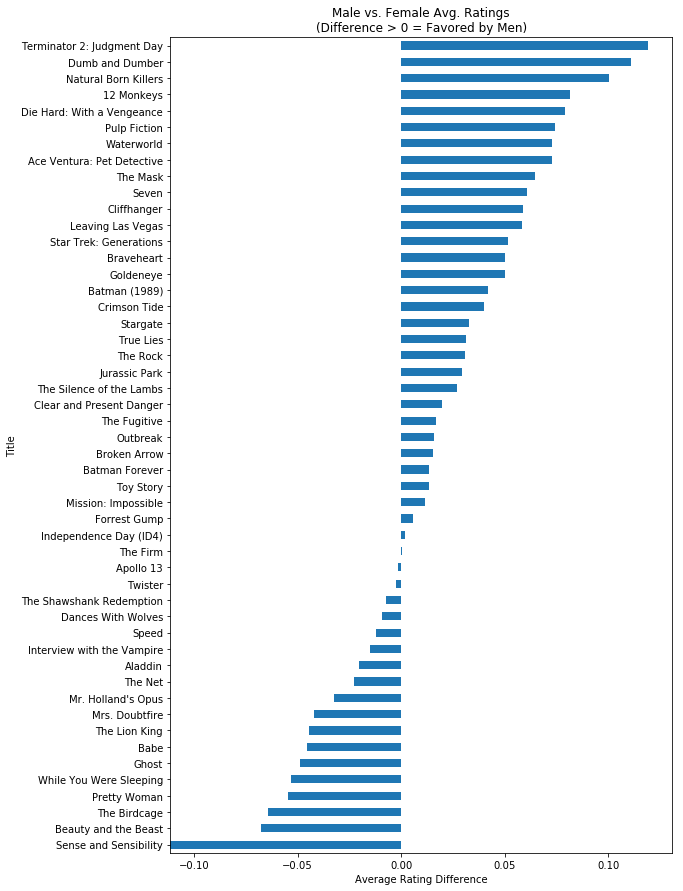

In [35]:
disagreements = pivoted[pivoted.movie_id.isin(most_50.index)]['diff']
disagreements.sort_values().plot(kind='barh', figsize=[9, 15])
plt.title('Male vs. Female Avg. Ratings\n(Difference > 0 = Favored by Men)')
plt.ylabel('Title')
plt.xlabel('Average Rating Difference');
plt.show()

The movie favourited by Male audience is **Terminator**. This is not a surprise.
The movie extremely favourited by Female audience is **Sense and Sensibility**. 
The movie liked the same by both genders is **The Firm**.

Let's see how old is this dataset by extracting their release dates from their names. The attempt to use the data from release data column wasn't a success because the most of the values in the column are not defined.

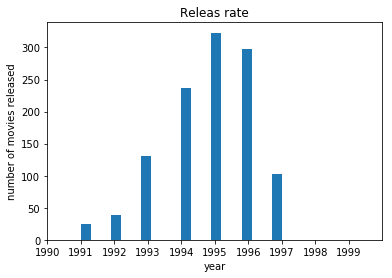

In [36]:
movies['release_date_relative'] = pd.to_datetime(movies['release_date_relative'])
movies['year'], movies['month'] = movies['release_date_relative'].dt.year, movies['release_date_relative'].dt.month

movies['year_parsed'] = movies['IMDb_URL'].str.extract(r"\(([1-9]+)\)", expand=False)
movies.year_parsed = movies.year_parsed.astype(float)
#print(movies.year)
movies.year_parsed.plot.hist(bins=250)
plt.title("Releas rate")
plt.ylabel('number of movies released')
plt.xlabel('year');
plt.xlim([1990,2000])
plt.xticks(range(1990,2000,1))
plt.show()

We see that the largest amount of movies in this dataset is released in **1995**. The movies come frome 90s.